# The Higgs to four lepton analysis from the ATLAS Open Data release of 2020, with RDataFrame

This exercise is the Higgs to four lepton analysis from the ATLAS Open Data release in 2020 (http://opendata.atlas.cern/release/2020/documentation/). The data was taken with the ATLAS detector during 2016 at a center-of-mass energy of 13 TeV. The decay of the Standard Model Higgs boson to two Z bosons and subsequently to four leptons is called the "golden channel". The selection leads to a narrow invariant mass peak on top a relatively smooth and small background, revealing the Higgs at 125 GeV. Systematic errors for the MC scale factors are computed and the Vary function of RDataFrame is used for plotting. The analysis is translated to an RDataFrame workflow processing about 300 MB of simulated events and data.


In [1]:
import ROOT
import os

## Specifying the input dataset

In this exercise, we use a JSON config file to define the dataset specification. It contains the names of the files, together with metadata associated with different samples. The metadata contained in the JSON file is accessible within a [`DefinePerSample`](https://root.cern/doc/v628/classROOT_1_1RDF_1_1RInterface.html#a29d77593e95c0f84e359a802e6836a0e) call, through the [`RSampleInfo`](https://root.cern/doc/master/classROOT_1_1RDF_1_1RSampleInfo.html) class.

In [2]:
# The analysis needs custom code written in a separate header, so we include it here
ROOT.gInterpreter.Declare('#include "utils.h"')

dataset_spec = "dataset_spec.json"
df = ROOT.RDF.Experimental.FromSpec(dataset_spec)  # Creates a single dataframe for all the samples

df = df.DefinePerSample("xsecs", 'rdfsampleinfo_.GetD("xsecs")')
df = df.DefinePerSample("lumi", 'rdfsampleinfo_.GetD("lumi")')
df = df.DefinePerSample("sumws", 'rdfsampleinfo_.GetD("sumws")')
df = df.DefinePerSample("sample_category", 'rdfsampleinfo_.GetS("sample_category")')
df = df.DefinePerSample("scale", "scale(rdfslot_, rdfsampleinfo_)")

## Perform selections

We need to select events with exactly four good leptons conserving charge and lepton numbers. Note that all collections read by RDataFrame are implicitly handled as the `ROOT::RVec` type.

In [3]:
%%time
# Select electron or muon trigger
df = df.Filter("trigE || trigM")

# good_lep is the mask for the good leptons.
# The lepton types are PDG numbers and set to 11 or 13 for an electron or muon
# irrespective of the charge.

df = (
    df.Define(
        "good_lep",
        "abs(lep_eta) < 2.5 && lep_pt > 5000 && lep_ptcone30 / lep_pt < 0.3 && lep_etcone20 / lep_pt < 0.3",
    )
    .Filter("Sum(good_lep) == 4")
    .Filter("Sum(lep_charge[good_lep]) == 0")
    .Define("goodlep_sumtypes", "Sum(lep_type[good_lep])")
    .Filter("goodlep_sumtypes == 44 || goodlep_sumtypes == 52 || goodlep_sumtypes == 48")
)

# Apply additional cuts depending on lepton flavour
df = df.Filter(
    "GoodElectronsAndMuons(lep_type[good_lep], lep_pt[good_lep], lep_eta[good_lep], lep_phi[good_lep], lep_E[good_lep], lep_trackd0pvunbiased[good_lep], lep_tracksigd0pvunbiased[good_lep], lep_z0[good_lep])"
)

# Create new columns with the kinematics of good leptons
df = (
    df.Define("goodlep_pt", "lep_pt[good_lep]")
    .Define("goodlep_eta", "lep_eta[good_lep]")
    .Define("goodlep_phi", "lep_phi[good_lep]")
    .Define("goodlep_E", "lep_E[good_lep]")
    .Define("goodlep_type", "lep_type[good_lep]")
)

# Select leptons with high transverse momentum
df = df.Filter("goodlep_pt[0] > 25000 && goodlep_pt[1] > 15000 && goodlep_pt[2] > 10000")

CPU times: user 272 ms, sys: 8.31 ms, total: 280 ms
Wall time: 283 ms


## Definition of the relevant observables

In [4]:
%%time
# Reweighting of the samples is different for "data" and "MC".
# Use DefinePerSample to define which samples are MC and hence need reweighting
df = df.DefinePerSample("isMC", 'rdfsampleinfo_.Contains("mc")')
df = df.Define(
    "weight",
    "double x; return isMC ? weights(scaleFactor_ELE, scaleFactor_MUON, scaleFactor_LepTRIGGER, scaleFactor_PILEUP, scale, mcWeight, xsecs, sumws, lumi) :  1.;",
)

df = df.Define("m4l", "ComputeInvariantMass(goodlep_pt, goodlep_eta, goodlep_phi, goodlep_E)")

# Book histograms for the four different samples: data, higgs, zz and other (this is specific to this particular analysis)
histos = []
for sample_category in ["data", "higgs", "zz", "other"]:
    histos.append(
        df.Filter(f'sample_category == "{sample_category}"').Histo1D(
            ROOT.RDF.TH1DModel(f"{sample_category}", "m4l", 24, 80, 170),
            "m4l",
            "weight",
        )
    )


CPU times: user 180 ms, sys: 17.7 ms, total: 198 ms
Wall time: 206 ms


## Evaluate systematic uncertainties

The systematic uncertainty in this analysis is the MC scale factor uncertainty that depends on lepton kinematics such as pT or pseudorapidity. Muons uncertainties are negligible, as stated in https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/MUON-2018-03/. Electrons uncertainties are evaluated based on the plots available in https://doi.org/10.48550/arXiv.1908.00005. The uncertainties are linearly interpolated, using the `TGraph::Eval()` method, to cover a range of pT values covered by the analysis.


In [5]:
%%time
# Create one helper object to run the interpolation for the systematic uncertainty evaluation in the event loop
ROOT.gInterpreter.ProcessLine("VaryHelper variationsFactory;");

CPU times: user 25.6 ms, sys: 359 μs, total: 26 ms
Wall time: 25.7 ms


In [6]:
%%time
# Use the Vary method to add the systematic variations to the total MC scale factor ("weight") of the analysis.
df_variations_mc = (
    df.Filter("isMC == true")
    .Vary("weight", "variationsFactory(weight, goodlep_pt, goodlep_type)", ["up", "down"])
    .Histo1D(ROOT.RDF.TH1DModel("Invariant Mass", "m4l", 24, 80, 170), "m4l", "weight")
)
histos_mc = ROOT.RDF.Experimental.VariationsFor(df_variations_mc)

CPU times: user 5.46 s, sys: 64 ms, total: 5.53 s
Wall time: 5.56 s


## Retrieving histograms and plotting

We reached the end of the analysis part. We now evaluate the total MC uncertainty based on the variations. No computation graph was triggered yet, we trigger the computation graph for all histograms at once now, by calling 'histos_mc["nominal"].GetXaxis()'. Note, in this case the uncertainties are symmetric.

In [7]:
%%time
for i in range(0, histos_mc["nominal"].GetXaxis().GetNbins()):
    (
        histos_mc["nominal"].SetBinError(
            i, (histos_mc["weight:up"].GetBinContent(i) - histos_mc["nominal"].GetBinContent(i))
        )
    )

CPU times: user 8.21 s, sys: 196 ms, total: 8.41 s
Wall time: 12 s


Make the plot of the data, individual MC contributions and the total MC scale factor systematic variations.

CPU times: user 166 ms, sys: 12.7 ms, total: 179 ms
Wall time: 189 ms


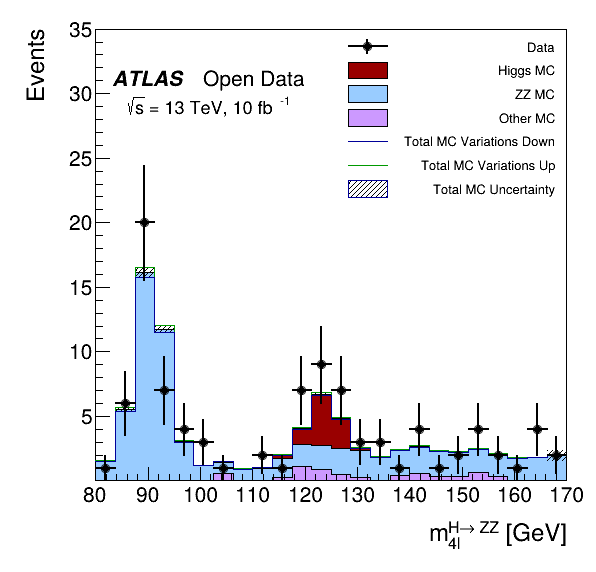

In [8]:
%%time
ROOT.gROOT.SetStyle("ATLAS")

# Create canvas with pad
c1 = ROOT.TCanvas("c", "", 600, 600)
pad = ROOT.TPad("upper_pad", "", 0, 0, 1, 1)
pad.SetTickx(False)
pad.SetTicky(False)
pad.Draw()
pad.cd()

# Draw stack with MC contributions
stack = ROOT.THStack()

# Retrieve values of the data and MC histograms in order to plot them.
# Draw cloned histograms to preserve graphics when original objects goes out of scope
# Note: GetValue() action operation is performed after all lazy actions of the RDF were defined first.
h_data = histos[0].GetValue().Clone()
h_higgs = histos[1].GetValue().Clone()
h_zz = histos[2].GetValue().Clone()
h_other = histos[3].GetValue().Clone()

for h, color in zip([h_other, h_zz, h_higgs], [ROOT.kViolet-9, ROOT.kAzure-9, ROOT.kRed+2]):
    h.SetLineWidth(1)
    h.SetLineColor(1)
    h.SetFillColor(color)
    stack.Add(h)

stack.Draw("HIST")
stack.GetXaxis().SetLabelSize(0.04)
stack.GetXaxis().SetTitleSize(0.045)
stack.GetXaxis().SetTitleOffset(1.3)
stack.GetXaxis().SetTitle("m_{4l}^{H#rightarrow ZZ} [GeV]")
stack.GetYaxis().SetLabelSize(0.04)
stack.GetYaxis().SetTitleSize(0.045)
stack.GetYaxis().SetTitle("Events")
stack.SetMaximum(35)
stack.GetYaxis().ChangeLabel(1, -1, 0)

# Draw MC scale factor and variations
histos_mc["nominal"].SetFillColor(ROOT.kBlack)
histos_mc["nominal"].SetFillStyle(3254)
h_nominal = histos_mc["nominal"].DrawClone("E2 same")
histos_mc["weight:up"].SetLineColor(ROOT.kGreen+2)
h_weight_up = histos_mc["weight:up"].DrawClone("HIST SAME")
histos_mc["weight:down"].SetLineColor(ROOT.kBlue+2)
h_weight_down = histos_mc["weight:down"].DrawClone("HIST SAME")

# Draw data histogram
h_data.SetMarkerStyle(20)
h_data.SetMarkerSize(1.2)
h_data.SetLineWidth(2)
h_data.SetLineColor(ROOT.kBlack)
h_data.Draw("E SAME")  # Draw raw data with errorbars

# Add legend
legend = ROOT.TLegend(0.57, 0.65, 0.94, 0.94)
legend.SetTextFont(42)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.SetTextSize(0.025)
legend.SetTextAlign(32)
legend.AddEntry(h_data, "Data", "lep")
legend.AddEntry(h_higgs, "Higgs MC", "f")
legend.AddEntry(h_zz, "ZZ MC", "f")
legend.AddEntry(h_other, "Other MC", "f")
legend.AddEntry(h_weight_down, "Total MC Variations Down", "l")
legend.AddEntry(h_weight_up, "Total MC Variations Up", "l")
legend.AddEntry(h_nominal, "Total MC Uncertainty", "f")
legend.Draw()

text = ROOT.TLatex()
text.SetTextFont(72)
text.SetTextSize(0.04)
text.DrawLatexNDC(0.19, 0.85, "ATLAS")
text.SetTextFont(42)
text.DrawLatexNDC(0.19 + 0.15, 0.85, "Open Data")
text.SetTextSize(0.035)
text.DrawLatexNDC(0.21, 0.80, "#sqrt{s} = 13 TeV, 10 fb^{-1}")

c1.Draw()

## TTree -> RNTuple conversion

In [20]:
%%cpp -d
import json

with open("dataset_spec.json", "r") as f:
    dataset = json.load(f)

treename = "mini"
ntuplename = "mini"
treefilenames = []

for i in dataset['samples'].keys():
    

TypeError: none of the 2 overloaded methods succeeded. Full details:
  static unique_ptr<ROOT::Experimental::RNTupleImporter,default_delete<ROOT::Experimental::RNTupleImporter> > ROOT::Experimental::RNTupleImporter::Create(TTree* sourceTree, string_view destFileName) =>
    TypeError: takes at most 2 arguments (3 given)
  static unique_ptr<ROOT::Experimental::RNTupleImporter,default_delete<ROOT::Experimental::RNTupleImporter> > ROOT::Experimental::RNTupleImporter::Create(string_view sourceFileName, string_view treeName, string_view destFileName) =>
    TypeError: could not convert argument 1

In [ ]:
# Retrieve the list of ROOT files and the TTree name from the dataset_spec
file_list = dataset_spec["files"]  # List of ROOT file paths
tree_name = dataset_spec["treename"]  # Name of the TTree

# Loop over each ROOT file in the dataset and convert its TTree to an RNTuple
for root_file in file_list:
    print(f"Processing file: {root_file}")
    
    # Open each ROOT file and retrieve the TTree
    with ROOT.TFile.Open(root_file, "READ") as input_file:
        if not input_file or input_file.IsZombie():
            raise RuntimeError(f"Error: Cannot open file '{root_file}'!")

        tree = input_file.Get(tree_name)
        if not tree:
            raise RuntimeError(f"Error: TTree '{tree_name}' not found in '{root_file}'!")

        # Use RNTupleImporter to convert the TTree to an RNTuple
        importer = ROOT.Experimental.RNTupleImporter(tree, ntuple_name, output_file_path)
        importer.Import()

print(f"Conversion completed! RNTuple '{ntuple_name}' saved to '{output_file_path}'.")